In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%pip install --upgrade pip
%pip install quickdraw

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from quickdraw import QuickDrawDataGroup
import numpy as np

import tensorflow as tf
from keras import layers
import time
import matplotlib.pyplot as plt
%matplotlib inline

from PIL.Image import fromarray, ANTIALIAS
from IPython.display import display as dprint

import cv2

In [4]:
# Settings

compress_size = 48      # Keep as a multiple of 4 (for the purpose of neural net and convolution layers)
num_drawings = None     # None implies download all drawings
category = ["bat"]
BATCH_SIZE = 16
EPOCHS = 15
noise_dim = 100

In [5]:
# Calculations

compress_shape = (compress_size, compress_size)
base_size = compress_size//4
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
category_list = "_".join(sorted(category))

In [6]:
# Functions

def resize_image(array_2d_255, shape):
    img = fromarray(np.uint8(array_2d_255))
    img = img.resize(shape, ANTIALIAS)
    return img

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def process_drawings(drawings):
    imgs = list()
    for drawing in drawings:
        img = drawing.get_image().convert('L')
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        for i in range(3 - compress_size//100):
            img = cv2.erode(np.array(img), kernel)
        img = resize_image(img, compress_shape)
        imgs.append(np.uint8(img))
    return imgs

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(base_size*base_size*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((base_size, base_size, 256)))
    assert model.output_shape == (None, base_size, base_size, 256)

    model.add(layers.Conv2DTranspose(150, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, base_size, base_size, 150)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(125, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, base_size, base_size, 125)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(100, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, base_size, base_size, 100)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(75, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, base_size, base_size, 75)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, base_size*2, base_size*2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, base_size*4, base_size*4, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[compress_size, compress_size, 1], activation="LeakyReLU"))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[compress_size, compress_size, 1], activation="LeakyReLU"))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                        input_shape=[compress_size, compress_size, 1], activation="LeakyReLU"))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation="LeakyReLU"))
    model.add(layers.MaxPooling2D(pool_size=(3,3), strides=2))
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [7]:
try:
    with open(f'training_{category_list}_{compress_size}.npy', 'rb') as f:
        training = np.load(f)
except:
    imgs = list()
    for item in category:
        dgs = QuickDrawDataGroup(item, max_drawings=num_drawings)
        imgs += process_drawings(dgs.drawings)
    training = np.array(imgs)
    
    with open(f'training_{category_list}_{compress_size}.npy', 'wb') as f:
        np.save(f, training)

num_drawings = training.shape[0]

downloading bat from https://storage.googleapis.com/quickdraw_dataset/full/binary/bat.bin
download complete
loading bat drawings
load complete


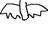

In [8]:
fromarray(training[np.random.randint(training.shape[0])])

In [9]:
train_images = training.reshape(training.shape[0], compress_size, compress_size, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(num_drawings).batch(BATCH_SIZE)

In [11]:
generator = make_generator_model()

def generate_random_image():
    noise = tf.random.uniform([1, noise_dim])
    generated_image = generator(noise, training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()
    return generated_image

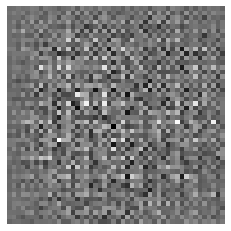

In [12]:
generated_image = generate_random_image()

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.500014]], shape=(1, 1), dtype=float32)


In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [17]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 188.57169198989868 sec
Time for epoch 2 is 146.36149501800537 sec
Time for epoch 3 is 201.59601140022278 sec
Time for epoch 4 is 215.77700114250183 sec


KeyboardInterrupt: 

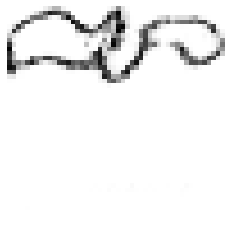

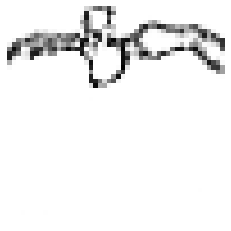

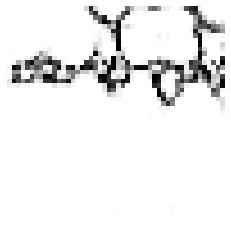

In [63]:
_ = generate_random_image()
_ = generate_random_image()
_ = generate_random_image()